# Model Selection - HOMES

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error,r2_score
from scipy.stats import randint, uniform,loguniform
import matplotlib.pyplot as plt
import os
os.chdir("../..")
from sibr_module import BigQuery, Logger, CStorage

from src.sibr_market_training import ParamTuning
import sklearn
from sklearn.svm import SVR

/Users/sigvardbratlie/Documents/Projects/sibr_market_training/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
dataset = 'homes'
logger = Logger(f'model_selection{dataset.capitalize()}')
bq = BigQuery(logger=logger, dataset=dataset)
cs = CStorage(logger=logger, bucket_name='sibr-market-bucket')
logger.debug(f'Dataset: {dataset}')

2025-08-05 12:55:29,857 - model_selectionHomes - INFO - Cloud Logging is disabled. Using local logging to /Users/sigvardbratlie/Documents/Projects/sibr_market_training/logfiles/model_selectionHomes.log
2025-08-05 12:55:29,860 - model_selectionHomes - INFO - BigQuery client initialized with project_id: sibr-market
2025-08-05 12:55:29,861 - model_selectionHomes - INFO - Google Cloud Storage client initialized with bucket: sibr-market-bucket
2025-08-05 12:55:29,862 - model_selectionHomes - DEBUG - Dataset: homes


In [3]:
a_n = ['ownership_type_annet', 'utdanning_Personer', 'utdanning_PersonerProsent', 'sqm_pr_bedroom', 'ownership_type_obligasjon']
h_n = ['property_type_bygård_flermannsbolig', 'ownership_type_obligasjon', 'ownership_type_annet', 'eq_lift_tmp_True', 'utdanning_PersonerProsent']

data = bq.read_homes(task = "train",random_samples=0.4, limit = 4000)
df_a = data.get("homes_apartments")
df_h = data.get("homes_houses")
df_o = data.get("homes_oslo")

2025-08-05 12:55:36,118 - model_selectionHomes - INFO - 4000 rows read from homes. Query: 
                            SELECT
                a.*,
                CASE
                    WH... (truncated)
2025-08-05 12:55:40,698 - model_selectionHomes - INFO - 4000 rows read from homes. Query: 
                            SELECT
                a.*,
                CASE
                    WH... (truncated)
2025-08-05 12:55:45,087 - model_selectionHomes - INFO - 4000 rows read from homes. Query: 
            WITH OsloHomes AS (
                SELECT
                h.*,
                go.BYDE... (truncated)


In [4]:
params_rf = {
    # RandomForest har allerede 5 parametere, noe som er innenfor grensen.
    # Disse er generelt ansett som viktige for Random Forest.
    'model__n_estimators': randint(100, 1500),  # Litt redusert øvre grense for raskere søk
    'model__max_depth': randint(5, 50),        # Redusert øvre grense
    'model__min_samples_leaf': randint(1, 10),
    'model__bootstrap': [True, False],
    'model__random_state': randint(0, 100)     # Inkludert som i din originale kode
}

params_xgb = {
    # Velger 4 kjerne-ytelsesparametere + random_state (totalt 5)
    'model__n_estimators': randint(100, 1500),
    'model__learning_rate': loguniform(0.01, 0.3),
    'model__max_depth': randint(3, 15),           # Litt justert range
    'model__subsample': uniform(0.6, 0.4),        # Genererer fra 0.6 til 1.0
    'model__colsample_bytree': uniform(0.6, 0.4), # Kan legges til hvis du vil ha 5 ytelsesparams + random_state
    'model__reg_lambda': loguniform(1e-8, 1.0),   # Alternativ til subsample/colsample
    'model__random_state': randint(0, 100)
}

params_cat = {
    # Velger 4 kjerne-ytelsesparametere. random_state er fast.
    'model__iterations': randint(100, 1500),      # Samme som n_estimators
    'model__learning_rate': loguniform(0.01, 0.3),
    'model__depth': randint(3, 10),               # Samme som max_depth
    'model__l2_leaf_reg': loguniform(1, 10),      # Viktig regulariseringsparameter for CatBoost
    # 'model__bagging_temperature': uniform(0, 1), # Kan legges til for en femte parameter
    'model__random_state': randint(0, 100)                     # Fast verdi, teller ikke mot justerbare
}

params_svr = {
    'model__kernel': [
                    #'linear', 
                      'rbf', 
                      #'poly'
                      ],
    'model__C': loguniform(1, 200),
    'model__gamma': loguniform(0.001, 1),
    'model__epsilon': uniform(0.01, 0.5),
}

models = {
    #'RandomForest': (RandomForestRegressor(), params_rf),
    'XGBoost': (XGBRegressor(), params_xgb),
    #"SVR" : (SVR(),params_svr )
    #'CatBoost': (CatBoostRegressor(silent=True), params_cat),
}

In [5]:
a = ParamTuning(dataset_name='homes_apartments',
                 dataframe=df_a,
                 target='price',
                 model_params=models,
                 logger=logger,
                 log_target=True)
a.model_selection(models=models, cv = 5,n_iter = 100)

2025-08-05 12:55:51,434 - model_selectionHomes - INFO - 
 
 -------- MODEL SELECTION FOR HOMES_APARTMENTS --------
2025-08-05 12:55:51,444 - model_selectionHomes - INFO - Train set size: 3200, Test set size: 800
2025-08-05 12:55:51,444 - model_selectionHomes - INFO - Columns in train set: ['joint_debt', 'monthly_common_cost', 'collective_assets', 'bedrooms', 'internal_area', 'usable_area', 'external_area', 'floor', 'balcony', 'build_year', 'rooms', 'plot_size', 'sqm_pr_bedroom', 'dealer_True', 'fixer_upper_True', 'eq_parking_True', 'eq_lift_True', 'eq_fireplace_True', 'eq_charging_possibility_True', 'eq_aircondition_True', 'eq_garden_True', 'eq_parking_tmp_True', 'eq_lift_tmp_True', 'eq_west_facing_True', 'ownership_type_andel', 'ownership_type_annet', 'ownership_type_eier ', 'ownership_type_obligasjon', 'day', 'month', 'year', 'ref_price_pr_i_sqm', 'ref_price_pr_i_sqm_1', 'ref_salgstid', 'lat', 'lng', 'areal_befolkning_ArealKm2', 'areal_befolkning_FolkeLandArealKm2', 'areal_befolkning

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/sigvardbratlie/Documents/Projects/sibr_market_training/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2025-08-05 12:59:38,390 - model_selectionHomes - INFO - XGBoost model best parameters: {'model__colsample_bytree': np.float64(0.7669644012595116), 'model__learning_rate': np.float64(0.0212853192163843), 'model__max_depth': 5, 'model__n_estimators': 1357, 'model__random_state': 43, 'model__reg_lambda': np.float64(8.974374279504338e-07), 'model__subsample': np.float64(0.6673164168691722)} on homes_apartments
2025-08-05 12:59:38,392 - model_selectionHomes - INFO - Best score for XGBoost: Train: 52138491904.0, Test: 603380383744.0, R2 (test): 0.9241090416908264, R2 (train): 0.9934866428375244 on homes_apartments 

2025-08-05 12:59:38,393 - model_selectionHomes - INFO -  
 ===== RESULTS FOR h

In [11]:
h = ParamTuning(dataset_name='homes_houses',
                 dataframe=df_h,
                 target='price',
                 model_params=models,
                 logger=logger,
                 log_target=True)
h.model_selection(models=models, cv = 5,n_iter = 100)

2025-08-05 13:07:59,148 - model_selectionHomes - INFO - 
 
 -------- MODEL SELECTION FOR HOMES_HOUSES --------
2025-08-05 13:07:59,155 - model_selectionHomes - INFO - Train set size: 3200, Test set size: 800
2025-08-05 13:07:59,156 - model_selectionHomes - INFO - Columns in train set: ['bedrooms', 'internal_area', 'usable_area', 'build_year', 'plot_size', 'sqm_pr_bedroom', 'dealer_True', 'fixer_upper_True', 'eq_parking_True', 'eq_lift_True', 'eq_fireplace_True', 'eq_charging_possibility_True', 'eq_aircondition_True', 'eq_garden_True', 'eq_parking_tmp_True', 'eq_lift_tmp_True', 'eq_west_facing_True', 'ownership_type_andel', 'ownership_type_annet', 'ownership_type_eier ', 'ownership_type_obligasjon', 'day', 'month', 'year', 'property_type_bygård_flermannsbolig', 'property_type_enebolig', 'property_type_gårdsbruk_småbruk', 'property_type_rekkehus', 'property_type_tomannsbolig', 'ref_price_pr_i_sqm', 'ref_price_pr_i_sqm_1', 'ref_salgstid', 'lat', 'lng', 'areal_befolkning_ArealKm2', 'areal_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/sigvardbratlie/Documents/Projects/sibr_market_training/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2025-08-05 13:12:45,857 - model_selectionHomes - INFO - XGBoost model best parameters: {'model__colsample_bytree': np.float64(0.7669644012595116), 'model__learning_rate': np.float64(0.0212853192163843), 'model__max_depth': 5, 'model__n_estimators': 1357, 'model__random_state': 43, 'model__reg_lambda': np.float64(8.974374279504338e-07), 'model__subsample': np.float64(0.6673164168691722)} on homes_houses
2025-08-05 13:12:45,859 - model_selectionHomes - INFO - Best score for XGBoost: Train: 215912579072.0, Test: 1991408353280.0, R2 (test): 0.8739627003669739, R2 (train): 0.9857589602470398 on homes_houses 

2025-08-05 13:12:45,859 - model_selectionHomes - INFO -  
 ===== RESULTS FOR homes_h

In [15]:
o = ParamTuning(dataset_name='homes_apartments_oslo',
                dataframe=df_o,
                target='price',
                model_params=models,
                logger=logger,
                log_target=True)
o.model_selection(models = models, cv = 5,n_iter = 100)

2025-08-05 13:46:48,439 - model_selectionHomes - INFO - 
 
 -------- MODEL SELECTION FOR HOMES_APARTMENTS_OSLO --------
2025-08-05 13:46:48,447 - model_selectionHomes - INFO - Train set size: 3200, Test set size: 800
2025-08-05 13:46:48,447 - model_selectionHomes - INFO - Columns in train set: ['joint_debt', 'monthly_common_cost', 'collective_assets', 'bedrooms', 'internal_area', 'usable_area', 'external_area', 'floor', 'balcony', 'build_year', 'rooms', 'plot_size', 'sqm_pr_bedroom', 'dealer_True', 'fixer_upper_True', 'eq_parking_True', 'eq_lift_True', 'eq_fireplace_True', 'eq_charging_possibility_True', 'eq_aircondition_True', 'eq_garden_True', 'eq_parking_tmp_True', 'eq_lift_tmp_True', 'eq_west_facing_True', 'ownership_type_andel', 'ownership_type_annet', 'ownership_type_eier ', 'ownership_type_obligasjon', 'day', 'month', 'year', 'ref_price_pr_i_sqm', 'ref_salgstid', 'lat', 'lng', 'ref_price', 'district_name_Alna', 'district_name_Bjerke', 'district_name_Frogner', 'district_name_Gaml

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/sigvardbratlie/Documents/Projects/sibr_market_training/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2025-08-05 13:49:00,221 - model_selectionHomes - INFO - XGBoost model best parameters: {'model__colsample_bytree': np.float64(0.6164270067071503), 'model__learning_rate': np.float64(0.03882458572802511), 'model__max_depth': 5, 'model__n_estimators': 1181, 'model__random_state': 54, 'model__reg_lambda': np.float64(1.0159778010164036e-06), 'model__subsample': np.float64(0.673733469732548)} on homes_apartments_oslo
2025-08-05 13:49:00,223 - model_selectionHomes - INFO - Best score for XGBoost: Train: 23847071744.0, Test: 802410987520.0, R2 (test): 0.9170135259628296, R2 (train): 0.9978551864624023 on homes_apartments_oslo 

2025-08-05 13:49:00,223 - model_selectionHomes - INFO -  
 ===== RE

In [12]:
cs

['eq_aircondition_True',
 'ownership_type_annet',
 'utdanning_PersonerProsent',
 'ownership_type_obligasjon']

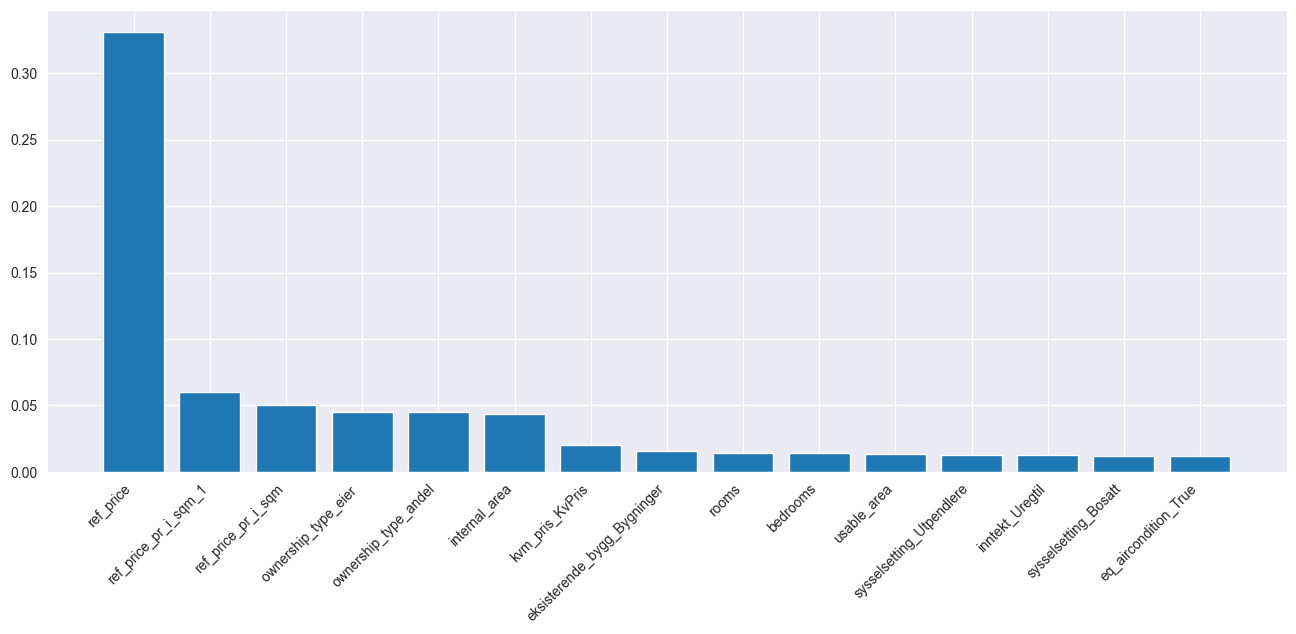

In [16]:
a_imp, a_notimp = a.get_feat_imp(0)
a.plot_feat_imp(0)

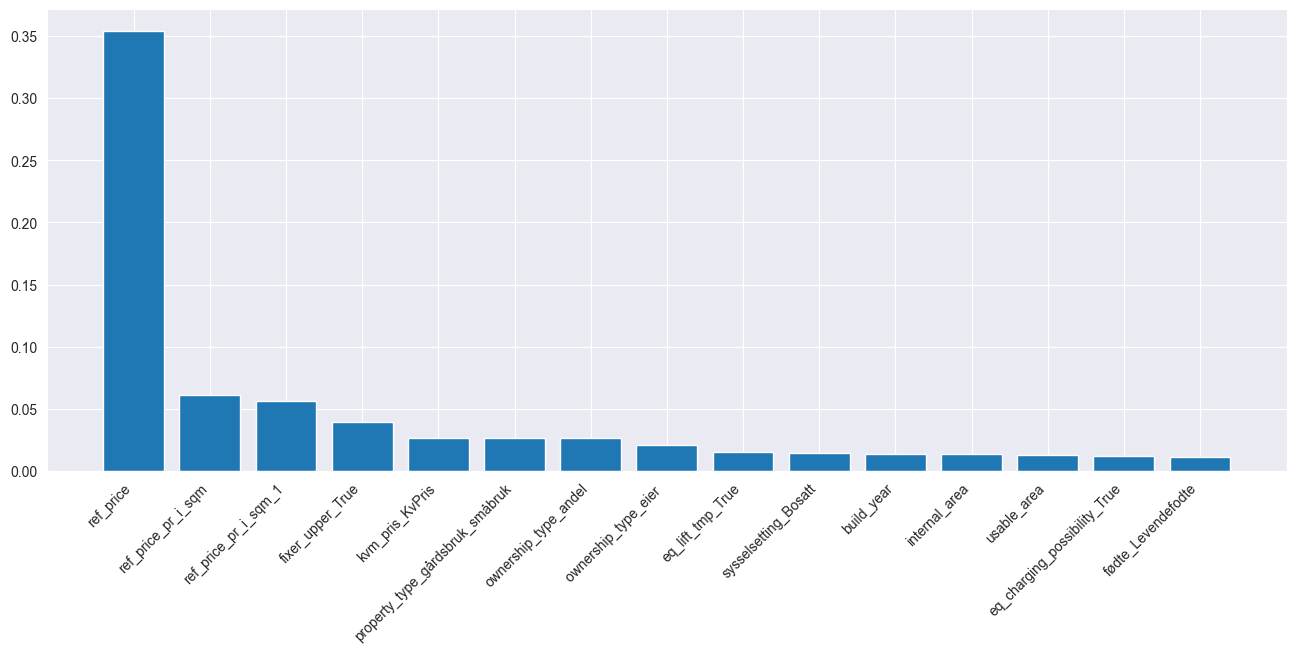

In [19]:
h_imp, h_notimp = h.get_feat_imp(0)
h.plot_feat_imp(0)

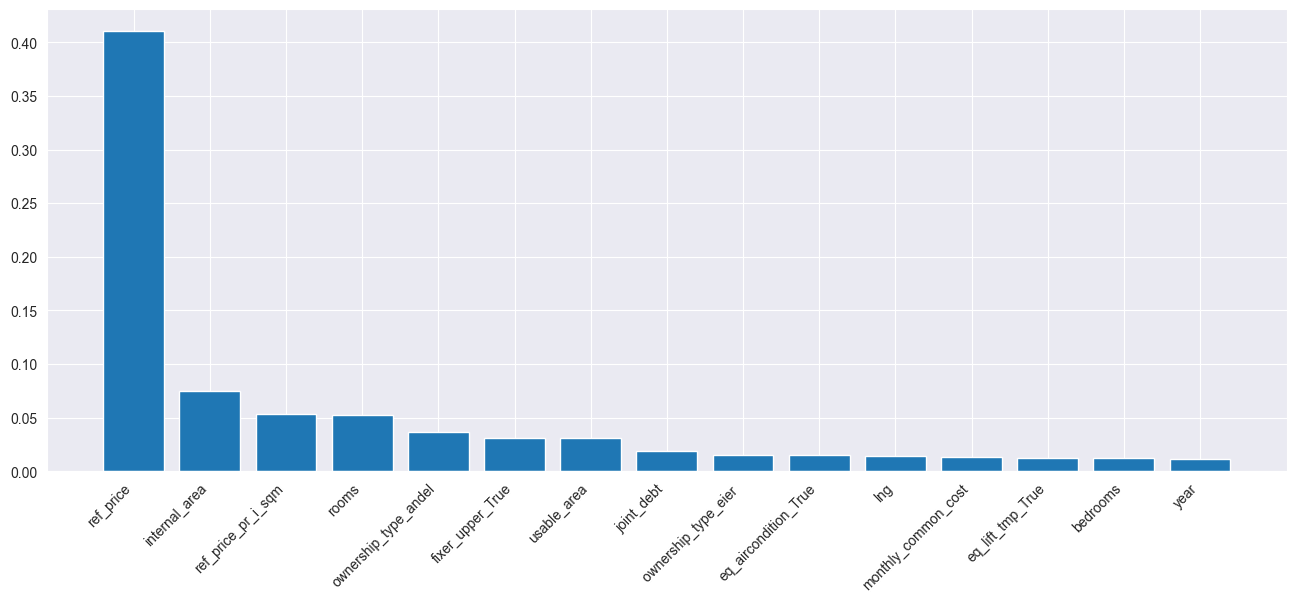

In [20]:
o_imp, o_notimp = o.get_feat_imp(0)
o.plot_feat_imp(0)

In [21]:
for f in [a_notimp, h_notimp, o_notimp]:
    print(f'{f}\n')

['utdanning_PersonerProsent', 'ownership_type_obligasjon', 'ownership_type_annet']

['utdanning_PersonerProsent', 'ownership_type_obligasjon']

['ownership_type_annet', 'ownership_type_obligasjon']



In [64]:
df_o['eq_west_facing_True'].value_counts()

eq_west_facing_True
False    3470
True      530
Name: count, dtype: Int64

In [26]:
df_a.sample(10)

,price,joint_debt,monthly_common_cost,collective_assets,bedrooms,internal_area,usable_area,external_area,floor,balcony,build_year,rooms,plot_size,sqm_pr_bedroom,dealer_True,fixer_upper_True,eq_parking_True,eq_lift_True,eq_fireplace_True,eq_charging_possibility_True,eq_aircondition_True,eq_garden_True,eq_parking_tmp_True,eq_lift_tmp_True,eq_west_facing_True,ownership_type_andel,ownership_type_annet,ownership_type_eier,ownership_type_obligasjon,day,month,year,ref_price_pr_i_sqm,ref_salgstid,lat,lng,areal_befolkning_ArealKm2,areal_befolkning_FolkeLandArealKm2,areal_befolkning_Folkemengde,areal_befolkning_LandArealKm2,inntekt_AvtArbTid,inntekt_AvtaltManedslonn,inntekt_Bonus,inntekt_Manedslonn,inntekt_Overtid,inntekt_Uregtil,husholdninger_Husholdninger,sysselsetting_Arbeidssted,sysselsetting_Bosatt,sysselsetting_Innpendlere,sysselsetting_Utpendlere,utdanning_Personer,utdanning_PersonerProsent,bedrifter_Virksheter,ref_price
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
378145345,2790000,0,0,13642,1,40,43,3,3,7,2022,2,3232,43,True,False,True,True,False,False,False,False,True,True,False,False,False,True,False,7,1,2025,6.623404e+07,60.994872,63.283260,10.274540,694,27,17560,653,28.8,50500.0,470.0,52780.0,950.0,1820.0,2531,2509,4163,904,2558,14368,100,1908,2.848064e+09
377821521,2995000,0,0,0,1,35,40,5,4,7,<NA>,2,<NA>,40,True,False,False,True,False,False,False,False,False,True,True,False,False,True,False,13,11,2024,2.611116e+09,32.036842,63.404560,10.448430,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1.044446e+11
379628619,4200000,145000,0,17358,1,39,43,4,2,0,1900,2,474,43,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,20,11,2024,1.004748e+05,20.390909,59.927220,10.748820,454,1683,717710,426,30.4,63200.0,2830.0,67350.0,810.0,1320.0,178282,256432,198430,87663,29661,607167,100,105243,4.320418e+06
409851043,3290000,0,2567,0,0,69,71,2,0,4,1882,2,416,71,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,4,6,2025,6.272629e+04,48.418182,63.434800,10.397600,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,4.453566e+06
406601617,4500000,120000,0,21448,1,39,41,2,1,0,1895,2,831,41,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,14,5,2025,1.187637e+05,18.339286,59.926540,10.725390,454,1683,717710,426,30.4,63200.0,2830.0,67350.0,810.0,1320.0,178282,256432,198430,87663,29661,607167,100,105243,4.869310e+06
355105110.0,2890000,0,2012,846,0,22,24,2,2,3,2020,1,1235,24,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,12,6,2024,3.183920e+10,40.679775,NaN,NaN,377,271,98815,364,29.1,56830.0,1550.0,59990.0,850.0,1610.0,13843,18106,25004,7062,13960,81144,100,11188,7.641408e+11
325110931,1590000,397000,0,22993,1,31,38,7,2,0,1957,2,2115,38,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,17,11,2024,4.522654e+04,51.283951,59.264560,10.424910,329,181,59174,326,29.3,53420.0,580.0,56300.0,990.0,2310.0,11636,17470,14703,7946,5179,49721,100,7659,1.718608e+06
411079533,3900000,52510,2389,28744,1,28,30,2,5,0,1901,2,470,30,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,19,6,2025,1.023487e+05,18.072464,59.929165,10.761732,454,1683,717710,426,30.4,63200.0,2830.0,67350.0,810.0,1320.0,178282,256432,198430,87663,29661,607167,100,105243,3.070461e+06
366959378,2650000,0,0,4882,1,37,42,5,1,5,2022,2,4179,42,True,False,True,True,False,False,False,False,True,True,True,False,False,True,False,7,1,2025,3.624797e+04,82.489796,59.260370,10.995050,293,300,85230,284,28.7,51120.0,830.0,53570.0,920.0,1620.0,15491,16147,19165,4135,7153,71790,100,8777,1.522415e+06
